In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.integrate import cumulative_trapezoid
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import time

# ==============================================================================
# --- 1. Setup: Constants & Thermodynamic Functions ---
# ==============================================================================

print("--- 1. Initializing constants and functions ---")

# --- Physical constants ---
g = constants.g
cpd = 1005.7
Rd  = 287.05
Rv  = 461.5
epsilon = Rd / Rv
Lv = 2.501e6
kappa = Rd / cpd # R_d / c_pd for rescaling panel (a) & (b)

# --- Thermodynamic utilities ---
def saturation_vapor_pressure(T):
    """Calculates saturation vapor pressure (Pa) from temperature (K)."""
    T_c = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_c)/(T_c + 243.5))
    return es_hPa * 100.0  # Pa

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (kg/kg) from pressure (Pa) and T (K)."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    # Use T for 'out' shape to handle (scalar, array) inputs
    qs = np.divide(epsilon * es, denom, out=np.full_like(T,1e-9), where=denom>0)
    return np.maximum(qs,1e-9)

def dqs_dT(p, T, dT=0.01):
    """Calculates d(qs)/dT via centered difference."""
    return (saturation_specific_humidity(p, T + dT)
          - saturation_specific_humidity(p, T - dT)) / (2*dT)

def dqs_dp(p, T, dp=10.0):
    """Calculates d(qs)/dp via centered difference."""
    return (saturation_specific_humidity(p + dp, T)
          - saturation_specific_humidity(p - dp, T)) / (2*dp)

def d2qs_dT2(p, T, dT=0.01):
    """Calculates d^2(qs)/dT^2 via centered difference."""
    qs_p = saturation_specific_humidity(p, T + dT)
    qs_0 = saturation_specific_humidity(p, T)
    qs_m = saturation_specific_humidity(p, T - dT)
    return (qs_p - 2*qs_0 + qs_m) / (dT**2)

def d2qs_dTdp(p, T, dT=0.01, dp=10.0):
    """Calculates d^2(qs)/dTdp via centered difference."""
    dT_plus  = dqs_dT(p + dp, T, dT)
    dT_minus = dqs_dT(p - dp, T, dT)
    return (dT_plus - dT_minus) / (2*dp)

def virtual_temperature(T, p):
    """Calculates virtual temperature (K)."""
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1 + (1/epsilon - 1)*qs)
    return np.maximum(Tv,10.0)

def calculate_mse(T, p, z):
    """Calculates moist static energy (J/kg)."""
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv * qs

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    """Calculates a moist adiabatic T profile (K) on p_grid (Pa)."""
    n = len(p_grid)
    T_prof = np.full(n, np.nan); z_prof = np.full(n, np.nan)
    T_prof[0], z_prof[0] = T_surf, 0.0
    mse0 = calculate_mse(T_surf, p_grid[0], 0.0)
    for i in range(n-1):
        T_cur, p_cur, z_cur = T_prof[i], p_grid[i], z_prof[i]
        p_next = p_grid[i+1]
        if np.isnan(T_cur) or p_cur <= 0: break
        Tv = virtual_temperature(T_cur, p_cur)
        dz = - (Rd * Tv / p_cur) / g * (p_next - p_cur)
        z_next = z_cur + dz
        def resid(Tg): return calculate_mse(Tg, p_next, z_next) - mse0
        try:
            br = [150.0, T_cur + 5.0]
            if resid(br[0]) * resid(br[1]) > 0: break
            sol = root_scalar(resid, bracket=br, method='brentq', xtol=1e-3)
            if sol.converged:
                T_prof[i+1], z_prof[i+1] = sol.root, z_next
            else: break
        except: break
    return T_prof

def nice_levels(z, n=10):
    """Helper function for 'clean' contour levels."""
    vmin = np.nanmin(z); vmax = np.nanmax(z)
    if not np.isfinite(vmin) or not np.isfinite(vmax):
        return np.linspace(0, 1, n+1)
    span = vmax - vmin
    raw  = span / n if span > 0 else 1.0
    pow10 = 10**np.floor(np.log10(raw))
    step  = pow10 * (1 if raw/pow10 < 2 else 2 if raw/pow10 < 5 else 5)
    lo = np.floor(vmin/step) * step
    hi = np.ceil (vmax/step) * step
    return np.arange(lo, hi + 0.5*step, step)

# ==============================================================================
# --- 2. 2D Calculation (for Panels b & d) ---
# ==============================================================================

print("--- 2. Starting 2D calculation (T vs. p) ---")
t0 = time.time()

# --- Grid & storage ---
T_surf_vals = np.arange(279, 320.1, 1.0)
Tmin_plot   = 280.0
plot_mask   = T_surf_vals >= Tmin_plot

p_s, p_top, dp = 100000.0, 10000.0, -50.0
p_grid = np.arange(p_s, p_top + dp, dp)
n_p, n_t = len(p_grid), len(T_surf_vals)

# --- Storage for 2D fields ---
cL_grid         = np.full((n_p, n_t), np.nan) # c_L (for overlay)
vol_ratio       = np.full((n_p, n_t), np.nan) # 1 + \tilde{\alpha}
share_ker       = np.full((n_p, n_t), np.nan) # f_d * f_L
logT_deriv      = np.full((n_p, n_t), np.nan) # (dlog(c_L)/dlogT)
# --- New fields for panel (b) overlay ---
tilde_alpha_grid = np.full((n_p, n_t), np.nan) # \tilde{\alpha}
criterion_grid  = np.full((n_p, n_t), np.nan) # R_v T / L_v

for j, Ts in enumerate(T_surf_vals):
    print(f"  Ts={Ts:.1f} K …", end='')
    Tprof = calculate_profile_with_rootfinder(Ts, p_s, p_grid)
    if np.isnan(Tprof[-1]):
        print(" fail"); continue
    print(" ok")
    
    alpha_d = Rd * Tprof / p_grid
    cL      = Lv * dqs_dT(p_grid, Tprof)
    alpha_L = Lv * dqs_dp(p_grid, Tprof) # This is L_v * dqs_dp
    D       = cpd + cL
    
    # This is d(log c_L) / dT
    cc_curv = (Lv / (Rv * Tprof**2)) - (2.0 / Tprof)

    # --- Store required fields ---
    cL_grid[:, j]   = cL
    share_ker[:, j] = (cpd * cL) / (D**2)
    
    # Calculate 1 + \tilde{\alpha} = 1 - (L_v * dqs_dp) / alpha_d
    with np.errstate(divide='ignore', invalid='ignore'):
        vol_ratio[:, j] = 1.0 - np.divide(alpha_L, alpha_d,
                                          out=np.full_like(alpha_d, np.nan),
                                          where=np.isfinite(alpha_d) & (alpha_d != 0))
    
    # Calculate (dlog(c_L)/dlogT) = T * (dlog(c_L)/dT)
    logT_deriv[:, j] = cc_curv * Tprof

    # --- Calculate fields for panel (b) overlay ---
    # \tilde{\alpha} = - (L_v * dqs_dp) / alpha_d
    with np.errstate(divide='ignore', invalid='ignore'):
        tilde_alpha = -np.divide(alpha_L, alpha_d,
                                out=np.full_like(alpha_d, np.nan),
                                where=np.isfinite(alpha_d) & (alpha_d != 0))
        tilde_alpha_grid[:, j] = tilde_alpha
    
    # Criterion: R_v * T / L_v
    criterion_grid[:, j] = (Rv * Tprof) / Lv

print(f"2D calculation done in {time.time() - t0:.1f}s")

# --- Create plotting slices (Ts >= 280 K) ---
p_hpa = p_grid / 100.0
T_plot = T_surf_vals[plot_mask]
Tmat, Pmat = np.meshgrid(T_plot, p_hpa)

# Panel (b) data: kappa * (1 + \tilde{\alpha}) * (dlog(c_L)/dlogT)
vr_plot = vol_ratio[:, maskT]
logT_deriv_plot = logT_deriv[:, maskT]
product_ab_plot = kappa * vr_plot * logT_deriv_plot

# Panel (d) data: f_d * f_L
product_cd_plot = share_ker[:, maskT]

# Overlay data for panel (d)
cL_plot = cL_grid[:,  maskT]

# Data for new overlay in panel (b): \tilde{\alpha} - (R_v T / L_v)
tilde_alpha_plot = tilde_alpha_grid[:, maskT]
criterion_plot = criterion_grid[:, maskT]
overlay_b_field = tilde_alpha_plot - criterion_plot


# ==============================================================================
# --- 3. 1D Calculation (for Panels a & c) ---
# ==============================================================================

print("--- 3. Starting 1D calculation (at 500 hPa) ---")
t0 = time.time()

p_1D = 50000.0 # 500 hPa
# --- Updated 1D Temperature Range ---
T_1D = np.arange(240.0, 300.1, 0.5)

# --- 1D calculation for Panel (c) ---
cL_vals_1D_c = Lv * dqs_dT(p_1D, T_1D)
D_vals_c = cpd + cL_vals_1D_c
f_d_1D = cpd / D_vals_c
f_L_1D = cL_vals_1D_c / D_vals_c
f_prod_1D_c = f_d_1D * f_L_1D
idx_crit_c = np.argmin(np.abs(cL_vals_1D_c - cpd))
T_crit_c = T_1D[idx_crit_c]

# --- 1D calculation for Panel (a) ---
alpha_d_1D = Rd * T_1D / p_1D
alpha_L_1D = Lv * dqs_dp(p_1D, T_1D) # This is L_v * dqs_dp

# Term 1: 1 + \tilde{\alpha} = 1 - (L_v * dqs_dp) / alpha_d
term_a1 = 1.0 - alpha_L_1D / alpha_d_1D

# Term 2: (dlog(c_L)/dlogT) = T * (dlog(c_L)/dT)
cc_curv_1D = (Lv / (Rv * T_1D**2)) - (2.0 / T_1D)
term_a2_unscaled = cc_curv_1D * T_1D

# --- New rescaled terms for Panel (a) plot ---
# Rescale term 2 by kappa = Rd/cpd
term_a2_rescaled = kappa * term_a2_unscaled

# Product for Panel (a)
f_prod_1D_a = term_a1 * term_a2_rescaled

print(f"1D calculation done in {time.time() - t0:.1f}s")
print(f"Critical temperature (c_L = c_pd) at 500 hPa: {T_crit_c:.1f} K")



--- 1. Initializing constants and functions ---
--- 2. Starting 2D calculation (T vs. p) ---
  Ts=279.0 K … ok
  Ts=280.0 K … ok
  Ts=281.0 K … ok
  Ts=282.0 K … ok
  Ts=283.0 K … ok
  Ts=284.0 K … ok
  Ts=285.0 K … ok
  Ts=286.0 K … ok
  Ts=287.0 K … ok
  Ts=288.0 K … ok
  Ts=289.0 K … ok
  Ts=290.0 K … ok
  Ts=291.0 K … ok
  Ts=292.0 K … ok
  Ts=293.0 K … ok
  Ts=294.0 K … ok
  Ts=295.0 K … ok
  Ts=296.0 K … ok
  Ts=297.0 K … ok
  Ts=298.0 K … ok
  Ts=299.0 K … ok
  Ts=300.0 K … ok
  Ts=301.0 K … ok
  Ts=302.0 K … ok
  Ts=303.0 K … ok
  Ts=304.0 K … ok
  Ts=305.0 K … ok
  Ts=306.0 K … ok
  Ts=307.0 K … ok
  Ts=308.0 K … ok
  Ts=309.0 K … ok
  Ts=310.0 K … ok
  Ts=311.0 K … ok
  Ts=312.0 K … ok
  Ts=313.0 K … ok
  Ts=314.0 K … ok
  Ts=315.0 K … ok
  Ts=316.0 K … ok
  Ts=317.0 K … ok
  Ts=318.0 K … ok
  Ts=319.0 K … ok
  Ts=320.0 K … ok
2D calculation done in 2.9s
--- 3. Starting 1D calculation (at 500 hPa) ---
1D calculation done in 0.0s
Critical temperature (c_L = c_pd) at 500 hPa: 2

--- 4. Generating new Figure 4 ---


/var/folders/vt/gqrlflhj10b1g04_6pcq_q3r0000gn/T/ipykernel_84187/1049063156.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


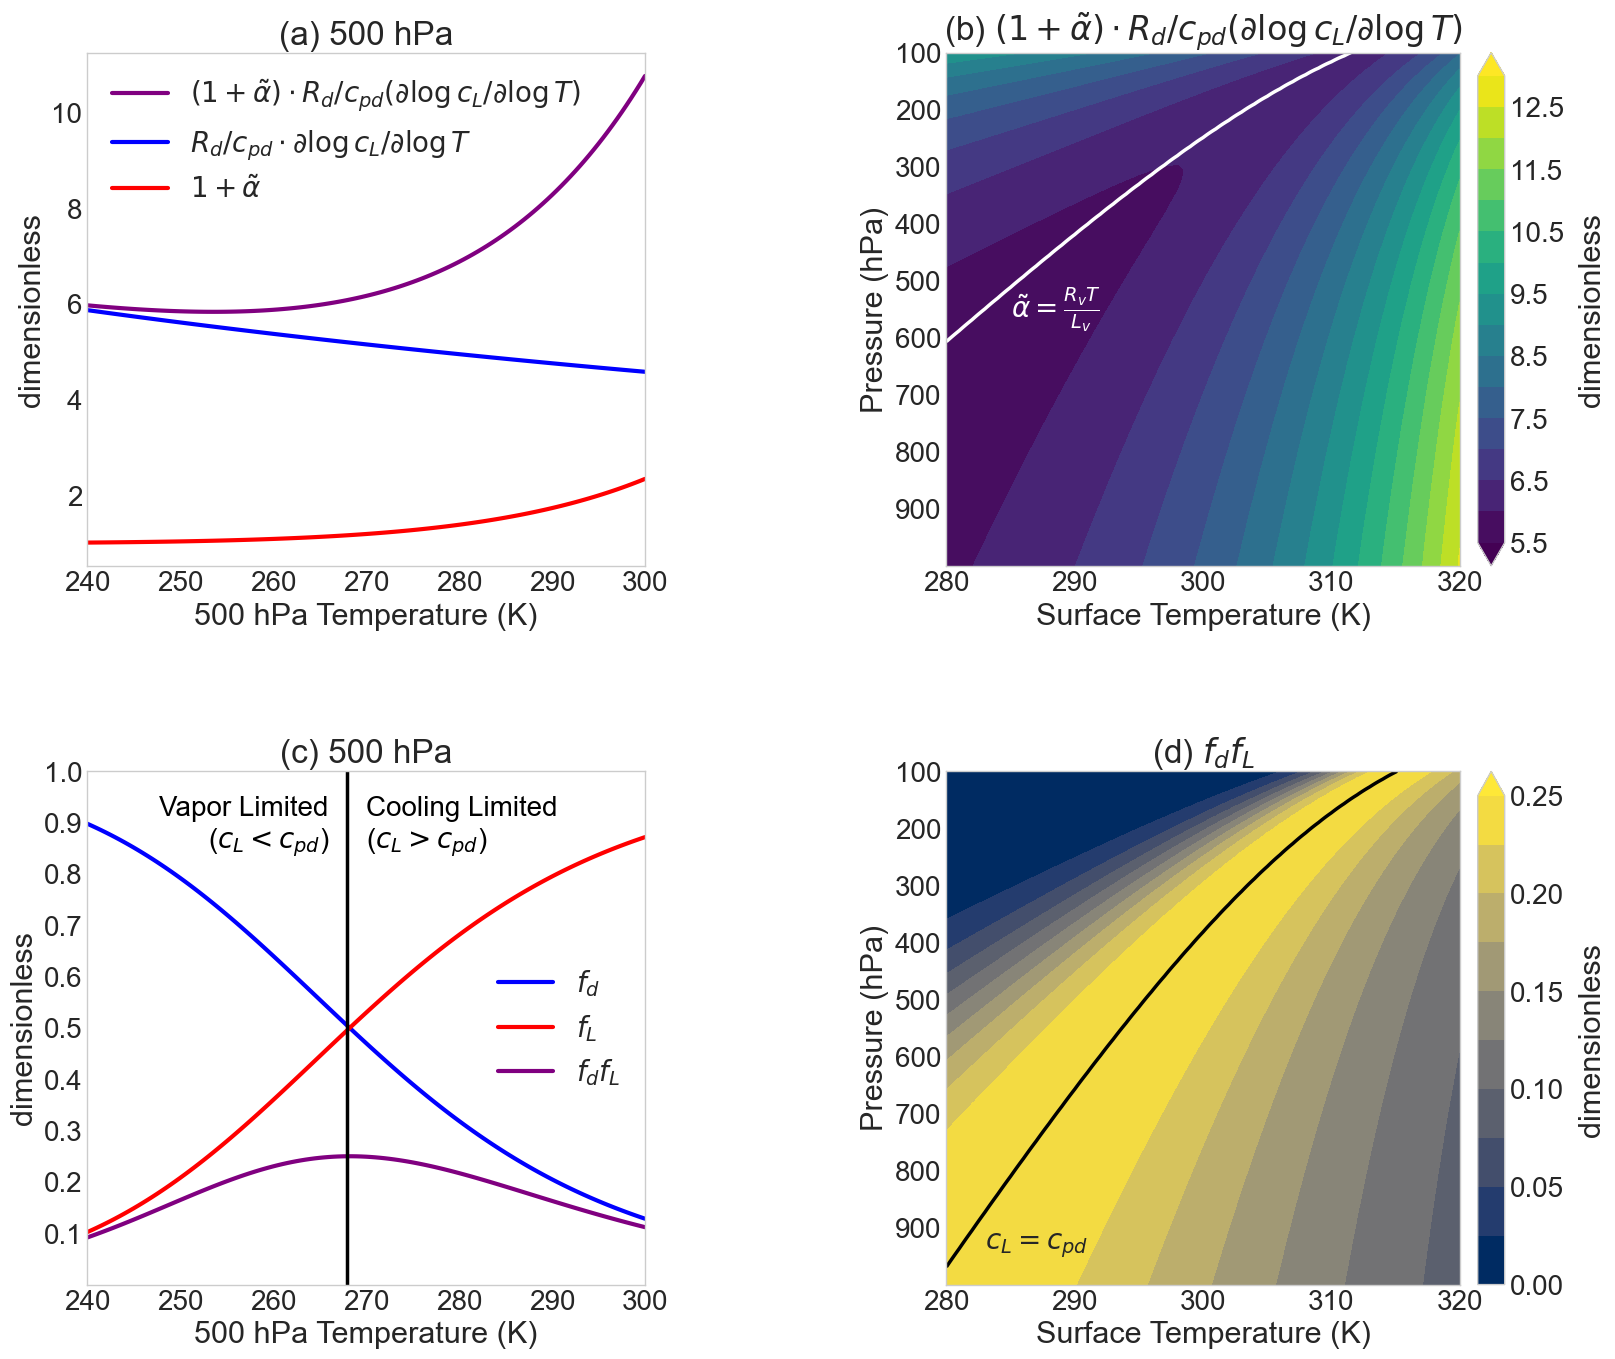

Figure 4 saved as fig-4.png


In [ ]:
# ==============================================================================
# --- 4. Plotting ---
# ==============================================================================

print("--- 4. Generating new Figure 4 ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size':22, 'axes.titlesize':24, 'axes.labelsize':22,
    'xtick.labelsize':20, 'ytick.labelsize':20, 'legend.fontsize':20
})

fig = plt.figure(figsize=(18, 16))
gs  = GridSpec(2, 2, hspace=0.4, wspace=0.5)

axs = {
    'a': fig.add_subplot(gs[0,0]),
    'b': fig.add_subplot(gs[0,1]),
    'c': fig.add_subplot(gs[1,0]),
    'd': fig.add_subplot(gs[1,1]),
}

# --- Setup contour plots (b) and (d) ---
for ax_name in ['b', 'd']:
    ax = axs[ax_name]
    ax.set_box_aspect(1)
    ax.set_xlabel('Surface Temperature (K)')
    ax.set_ylabel('Pressure (hPa)')
    ax.invert_yaxis()
    ax.set_ylim(1000,100)
    ax.set_yticks(np.arange(100,1000,100))

# --- Setup line plots (a) and (c) ---
for ax_name in ['a', 'c']:
    ax = axs[ax_name]
    ax.set_xlabel('500 hPa Temperature (K)')
    ax.set_xlim(T_1D[0], T_1D[-1])

# --- Panel (a): Line plot (Factors 1 & 2) ---
ax = axs['a']
# Plotting on a single y-axis
ln1 = ax.plot(T_1D, term_a1, label=r'$1 + \tilde{\alpha}$', color='red', lw=3)
ln2 = ax.plot(T_1D, term_a2_rescaled, label=r'$R_d/c_{pd} \cdot \partial \log c_L / \partial \log T$', color='blue', lw=3)
ln3 = ax.plot(T_1D, f_prod_1D_a, label=r'$(1 + \tilde{\alpha}) \cdot R_d / c_{pd} (\partial \log c_L / \partial \log T)$', color='purple', lw=3, ls='-')

ax.set_title('(a) 500 hPa')
ax.set_ylabel('dimensionless')

lns = ln3 + ln2 + ln1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left', fontsize=20)
ax.grid(False)

# --- Panel (b): Contour plot (Product of a, rescaled) ---
ax = axs['b']
lev_b = nice_levels(product_ab_plot, n=10)
cf_b = ax.contourf(Tmat, Pmat, product_ab_plot, levels=lev_b, cmap='viridis', extend='both')
ax.set_title(r'(b) $(1 + \tilde{\alpha}) \cdot R_d / c_{pd} (\partial \log c_L / \partial \log T)$')

ax.contour(Tmat, Pmat, overlay_b_field, levels=[0], colors='white', linewidths=2.5, linestyles='-')
ax.legend(handles=[
    Line2D([0],[0], color='white', lw=2.5, ls='-',  label=r'$\quad\quad\tilde{\alpha} = \frac{R_v T}{L_v}$')
], loc='center left', fontsize=20, handletextpad=-0.5, handlelength=0, labelcolor='white')

# --- Panel (c): Line plot (Factors 3 & 4) ---
ax = axs['c']
ax.plot(T_1D, f_d_1D, label=r'$f_d$', color='blue', lw=3)
ax.plot(T_1D, f_L_1D, label=r'$f_L$', color='red', lw=3)
ax.plot(T_1D, f_prod_1D_c, label=r'$f_d f_L$', color='purple', lw=3, ls='-')
ax.axvline(T_crit_c, color='k', ls='-', lw=2.5)

ax.text(T_crit_c - 2, 0.85, 'Vapor Limited\n($c_L < c_{pd}$)',
        horizontalalignment='right', fontsize=20, color='black')
ax.text(T_crit_c + 2, 0.85, 'Cooling Limited\n($c_L > c_{pd}$)',
        horizontalalignment='left', fontsize=20, color='black')

ax.set_title('(c) 500 hPa')
ax.set_ylabel('dimensionless')
ax.legend(loc='center right')
ax.set_ylim(0, 1.0)
ax.set_yticks(np.arange(0.1, 1.1, 0.1))
ax.grid(False)

# --- Panel (d): Contour plot (Product of c) ---
ax = axs['d']
lev_d = np.linspace(0, 0.25, 11)
cf_d = ax.contourf(Tmat, Pmat, product_cd_plot, levels=lev_d, cmap='cividis', extend='max')
ax.contour(Tmat, Pmat, cL_plot, levels=[cpd], colors='black', linewidths=2.5, linestyles='-')
ax.set_title(r'(d) $f_d f_L$')

ax.legend(handles=[
    Line2D([0],[0], color='black', lw=2.5, ls='-',  label=r'$c_L = c_{pd}$')
], loc='lower left', handletextpad=0.5, handlelength=0)

# --- Colorbars (aligned) ---
plt.tight_layout()
fig.canvas.draw()
cbar_w, cbar_pad = 0.015, 0.01

def add_cbar(ax, cf, label):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1 + cbar_pad, pos.y0, cbar_w, pos.height])
    cbar = fig.colorbar(cf, cax=cax, orientation='vertical')
    cbar.set_label(label, labelpad=10)

add_cbar(axs['b'], cf_b, 'dimensionless')
add_cbar(axs['d'], cf_d, 'dimensionless')

plt.savefig("fig-4.png", dpi=600, bbox_inches='tight')
plt.show()
print("Figure 4 saved as fig-4.png")
